In [4]:
pip uninstall torch -y

Found existing installation: torch 2.3.1
Uninstalling torch-2.3.1:
  Successfully uninstalled torch-2.3.1


In [5]:
pip uninstall -y torchtext

Found existing installation: torchtext 0.18.0
Uninstalling torchtext-0.18.0:
  Successfully uninstalled torchtext-0.18.0


In [6]:

pip uninstall -y torch torchtext torchvision torchaudio


Found existing installation: torchvision 0.18.1
Uninstalling torchvision-0.18.1:
  Successfully uninstalled torchvision-0.18.1
Found existing installation: torchaudio 2.3.1
Uninstalling torchaudio-2.3.1:
  Successfully uninstalled torchaudio-2.3.1


In [7]:
!pip install --no-cache-dir torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 torchtext==0.18.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 173.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 195.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 278.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 368.3 MB/s eta 0:00:00


best trans model saved
best trans model saved
best trans model saved
best trans model saved
best trans model saved
final test eval:

=== Precision / Recall / F1 ===
Accuracy:               0.9461
Macro Precision:        0.8572
Macro Recall:           0.8005
Macro F1:               0.7803
Weighted Precision:     0.9592
Weighted Recall:        0.9461
Weighted F1:            0.9444

=== Classification Report ===
                precision    recall  f1-score   support

  abbreviation       1.00      1.00      1.00        33
      aircraft       1.00      0.89      0.94         9
       airfare       0.87      1.00      0.93        48
       airline       0.86      0.97      0.91        38
       airport       0.90      1.00      0.95        18
      capacity       0.84      1.00      0.91        21
          city       0.46      1.00      0.63         6
      distance       1.00      0.80      0.89        10
        flight       0.98      0.96      0.97       632
flight+airfare       1.00 

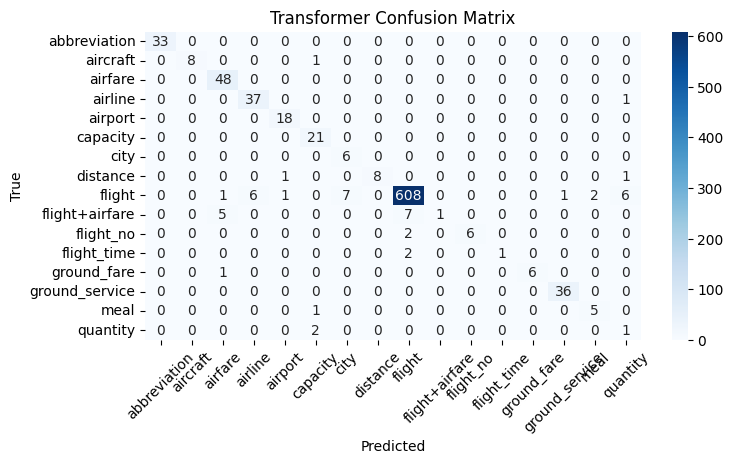

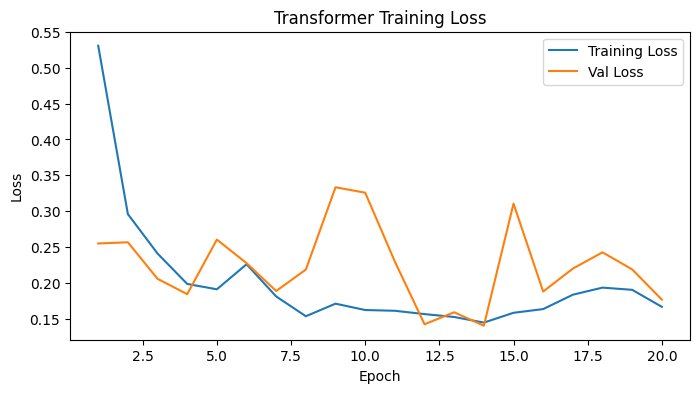

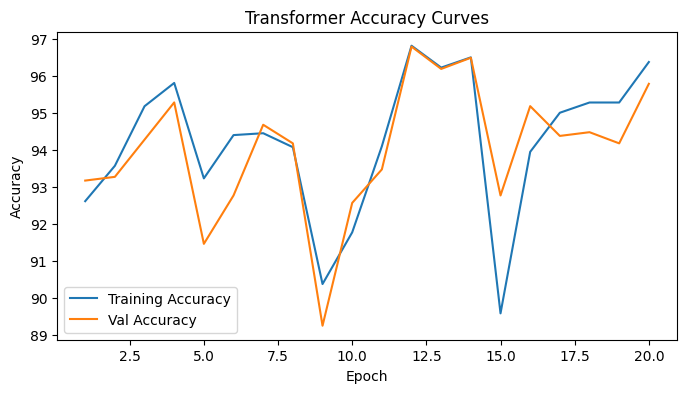

In [7]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from build_vocab import build_vocab
from token_and_augment import augment_dataframe, token_and_augment
from evaluation import evaluate
from transformer import TransformerModel
from bilstm_attention import ATISIntentDataset
import matplotlib.pyplot as plt
import seaborn as sns
import json

device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size= 32
max_len= 40
num_epochs= 20
lr= 1e-3
augment_frac= 1.0
aug_ins= 0.0
aug_del = 0.05
aug_rep = 0.05

train_csv="data/atis_train.csv"
val_csv="data/atis_val.csv"
test_csv= "data/atis_test.csv"


def compute_acc(model,loader):
    model.eval()
    correct=0
    total=0
    with torch.no_grad():
        for seq,label in loader:
            seq, label= seq.to(device),label.to(device)
            logits= model(seq)
            preds= logits.argmax(dim=1)
            correct+= (preds==label).sum().item()
            total += label.size(0)
    return 100.0 *correct/total if total >0 else 0.0



def main():
    train_df= pd.read_csv(train_csv)
    val_df= pd.read_csv(val_csv)
    test_df= pd.read_csv(test_csv)

    aug_train_df= augment_dataframe(train_df,frac=augment_frac,ins_p=aug_ins,del_p=aug_del,rep_p=aug_rep)
    with open("data/vocab.json","r") as f:
        vocab= json.load(f)
    word2idx= vocab["word2idx"]
    idx2word= vocab["idx2word"]
    vocab_size= len(word2idx)

    train_ds=ATISIntentDataset(aug_train_df,word2idx,augment=True,max_len=max_len)
    val_ds=ATISIntentDataset(val_df, word2idx, augment=False, max_len= max_len)
    test_ds= ATISIntentDataset(test_df, word2idx,augment=False,max_len=max_len)


    train_loader= DataLoader(train_ds,batch_size=batch_size, shuffle= True)
    val_loader= DataLoader(val_ds, batch_size=batch_size)
    test_loader= DataLoader(test_ds,batch_size=batch_size)

    num_classes= int(max(train_df["label"].max(),val_df["label"].max(),test_df["label"].max()))+1

    model= TransformerModel(
        num_classes=num_classes,
        d_model=300,
        num_layers=2,
        nhead=4,
        max_len=max_len,
        pad_id=word2idx["<pad>"],
        device=device).to(device)

    train_losses,val_losses,train_accs,val_accs=[],[],[],[]
    crit= nn.CrossEntropyLoss()
    optimizer= optim.Adam(model.parameters(),lr=lr)

    best_acc= 0.0


    for epoch in range(num_epochs):
        model.train()
        total_loss= 0
        for seq, label in train_loader:
            seq, label = seq.to(device),label.to(device)
            optimizer.zero_grad()
            logits= model(seq)
            loss= crit(logits,label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss_ep= total_loss/len(train_loader)
        train_acc_ep= compute_acc(model, train_loader)
        val_acc_ep= compute_acc(model, val_loader)

        model.eval()
        val_loss=0.0
        with torch.no_grad():
            for seq,label in val_loader:
                seq,label= seq.to(device),label.to(device)
                logits= model(seq)
                val_loss  += crit(logits,label).item()
        val_loss_ep= val_loss/len(val_loader)

        train_accs.append(train_acc_ep)
        val_accs.append(val_acc_ep)
        train_losses.append(train_loss_ep)
        val_losses.append(val_loss_ep)


        if val_acc_ep>best_acc:
            best_acc=val_acc_ep
            torch.save(model.state_dict(),"paths/Transformer_best.pt")
            print("best trans model saved")
    print("final test eval:")
    model.load_state_dict(torch.load("paths/Transformer_best.pt", map_location=device))
    label_id_to_string = (
    train_df.sort_values("label")
            .drop_duplicates("label")[["label", "intent"]]
            .set_index("label")["intent"]
            .to_dict()
)

    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for seq, label in test_loader:
            seq = seq.to(device)
            label = label.to(device)

            logits = model(seq)
            preds = logits.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    y_pred = np.array(all_preds)
    y_true = np.array(all_labels)

    cm = print_precision_metrics(y_true, y_pred, label_id_to_string)


    metrics, y_true, y_pred, cm = evaluate(
        model,
        test_loader,
        label_id_to_string,
        device=device,
        plot_cm=False
    )
    test_labels_present = sorted(set(y_true))
    target_names = [label_id_to_string[i] for i in test_labels_present]

    plt.figure(figsize=(8,4))
    sns.heatmap(cm, annot=True,fmt="d", cmap="Blues",xticklabels=target_names,yticklabels=target_names)
    plt.title("Transformer Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.savefig("paths/Transformer_confusion_matrix.png")
    plt.show()

    epochs= list(range(1,num_epochs+1))


    plt.figure(figsize=(8,4))
    plt.plot(epochs,train_losses,label="Training Loss")
    plt.plot(epochs,val_losses,label="Val Loss")
    plt.title("Transformer Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig("paths/Transformer_loss_curve.png")
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(epochs,train_accs,label="Training Accuracy")
    plt.plot(epochs,val_accs,label="Val Accuracy")
    plt.title("Transformer Accuracy Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig("paths/Transformer_acc_curve.png")
    plt.show()



main()

In [2]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

def print_precision_metrics(y_true, y_pred, label_id_to_string=None):
    # Basic metrics
    acc = accuracy_score(y_true, y_pred)
    precision_macro   = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro      = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro          = f1_score(y_true, y_pred, average='macro', zero_division=0)
    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_weighted    = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_weighted        = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Print results
    print("\n=== Precision / Recall / F1 ===")
    print(f"Accuracy:               {acc:.4f}")
    print(f"Macro Precision:        {precision_macro:.4f}")
    print(f"Macro Recall:           {recall_macro:.4f}")
    print(f"Macro F1:               {f1_macro:.4f}")
    print(f"Weighted Precision:     {precision_weighted:.4f}")
    print(f"Weighted Recall:        {recall_weighted:.4f}")
    print(f"Weighted F1:            {f1_weighted:.4f}")

    if label_id_to_string is not None:
        target_labels = sorted(set(y_true))
        target_names = [label_id_to_string[i] for i in target_labels]

        print("Classification Report")
        print(classification_report(
            y_true,
            y_pred,
            labels=target_labels,
            target_names=target_names,
            zero_division=0
        ))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    return cm
